<a href="https://colab.research.google.com/github/RiseAboveAll/RSNA_Pneumonia/blob/master/New_vgg_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydicom

     |████████████████████████████████| 35.5MB 89kB/s 


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import pydicom

import csv
import random

from glob import glob #The glob module finds all the pathnames matching a specified pattern according to the rules
import os

import tensorflow as tf
from tensorflow import keras

from skimage import measure
from skimage.transform import resize
from PIL import Image
from sklearn.model_selection import train_test_split as tts

import math
import cv2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
Path='/content/drive/My Drive/'
Image_Path='/content/drive/My Drive/Capstone/train_images/'
os.chdir(Path)

In [9]:
pneumonia_locations = {}
# load table
with open('/content/drive/My Drive/Capstone/stage_2_train_labels.csv', mode='r') as infile:
  # open reader
  reader = csv.reader(infile)
  # skip header
  next(reader, None)
  # loop through rows
  for rows in reader:
    # retrieve information
    filename = rows[0]
    location = rows[1:5]
    pneumonia = rows[5]
    # if row contains pneumonia add label to dictionary
    # which contains a list of pneumonia locations per filename
    if pneumonia == '1':
      # convert string to float to int
      location = [int(float(i)) for i in location]
      # save pneumonia location in dictionary
      if filename in pneumonia_locations:
        pneumonia_locations[filename].append(location)
      else:
        pneumonia_locations[filename] = [location]
folder = '/content/drive/My Drive/Capstone/train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples
folder = '/content/drive/My Drive/Capstone/train_images'

n train samples 24126
n valid samples 2560


In [61]:
pneumonia_locations

{'00436515-870c-4b36-a041-de91049b9ab4': [[264, 152, 213, 379],
  [562, 152, 256, 453]],
 '00704310-78a8-4b38-8475-49f4573b2dbb': [[323, 577, 160, 104],
  [695, 575, 162, 137]],
 '00aecb01-a116-45a2-956c-08d2fa55433f': [[288, 322, 94, 135],
  [547, 299, 119, 165]],
 '00c0b293-48e7-4e16-ac76-9269ba535a62': [[306, 544, 168, 244],
  [650, 511, 206, 284]],
 '00f08de1-517e-4652-a04f-d1dc9ee48593': [[181, 184, 206, 506],
  [571, 275, 230, 476]],
 '0100515c-5204-4f31-98e0-f35e4b00004a': [[703, 416, 84, 77]],
 '010ccb9f-6d46-4380-af11-84f87397a1b8': [[652, 437, 161, 293],
  [301, 405, 141, 279]],
 '012a5620-d082-4bb8-9b3b-e72d8938000c': [[133, 613, 275, 275],
  [678, 427, 224, 340]],
 '0174c4bb-28f5-41e3-a13f-a396badc18bd': [[155, 182, 273, 501],
  [599, 220, 227, 508]],
 '019d950b-dd38-4cf3-a686-527a75728be6': [[229, 318, 250, 301],
  [604, 216, 196, 328]],
 '01a6eaa6-222f-4ea8-9874-bbd89dc1a1ce': [[141, 306, 225, 327],
  [609, 285, 236, 355]],
 '01a7353d-25bb-4ff8-916b-f50dd541dccf': [[214, 

In [21]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)


In [22]:
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=False, predict=False)

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=5, use_multiprocessing=False)

NameError: ignored

## Model2 

In [12]:
def vgg_block(layer_in, n_filters, n_conv):
    for _ in range(n_conv):
        layer_in = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
    # add max pooling layer
    layer_in = keras.layers.MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_in
 
# define model input


In [13]:
visible=keras.layers.Input(shape=(256,256,1))
layer=vgg_block(visible,8,2)
layer=vgg_block(layer,16,2)
layer=vgg_block(layer,32,2)
layer=vgg_block(layer,64,3)
layer=vgg_block(layer,128,3)
layer = keras.layers.BatchNormalization(momentum=0.9)(layer)
layer = keras.layers.LeakyReLU(0)(layer)
layer = keras.layers.Conv2D(1, 1, activation='sigmoid')(layer)
outputs = keras.layers.UpSampling2D(2**5)(layer)
model1 = Model(inputs=visible, outputs=outputs)

In [14]:
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 8)       80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0     

In [15]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))



In [16]:
# create network and compiler
model1.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
PATIENCE = 3

In [17]:
def cosine_annealing(x):
    lr = 0.001
    epochs = 5
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)


# New Section

# New Section

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
checkpoint = ModelCheckpoint("model-seg-{val_mean_iou:.2f}.h5", monitor="val_mean_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max") 
stop = EarlyStopping(monitor="val_mean_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_mean_iou", factor=0.2, patience=3, min_lr=1e-5, verbose=1, mode="max")


In [ ]:
4892

In [ ]:
history = model1.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint,stop,reduce_lr], epochs=5, use_multiprocessing=False)

Epoch 1/5
593/753 [======================>.......] - ETA: 44:52 - loss: 0.5012 - accuracy: 0.9662 - mean_iou: 0.6573

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

for imgs, msks in valid_gen:fdsf# New Secsdsdfggdfgfgfffffffffdfssddcfczcxcvffon

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section Delete

# New Section

# New Section

# Command Run

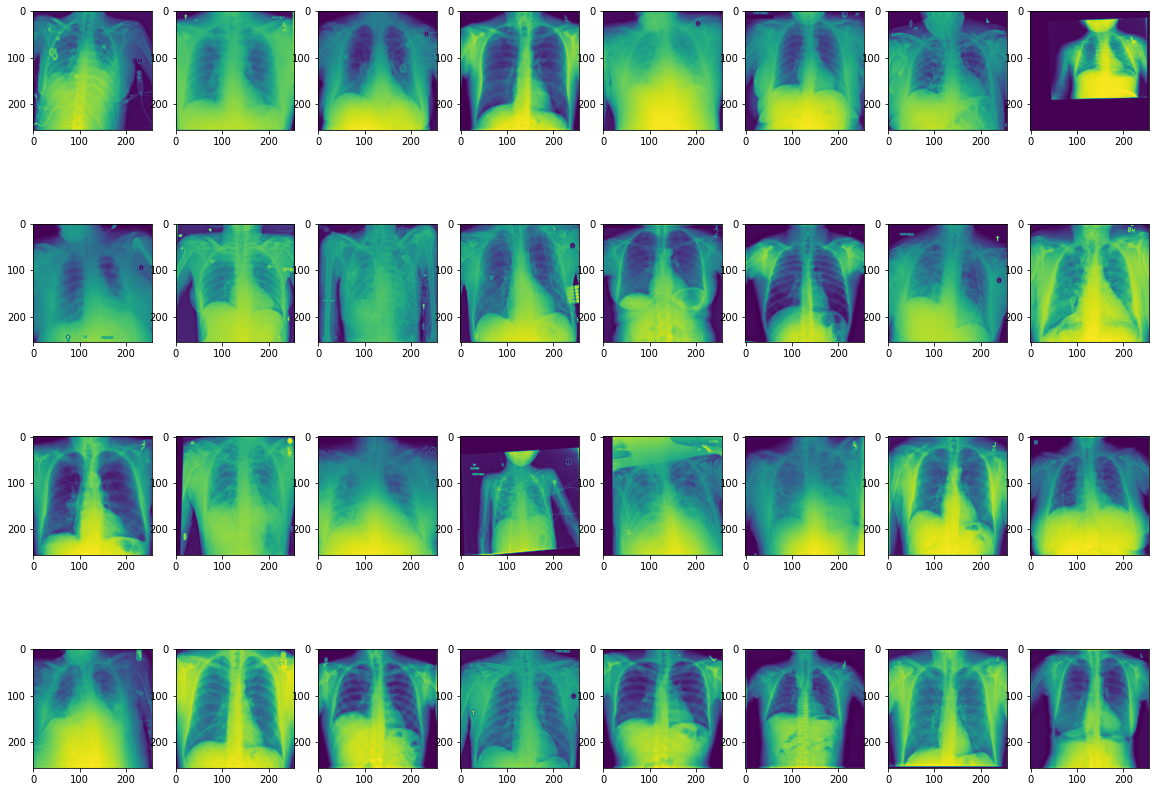

In [ ]:


for imgs, msks in valid_gen:
    # predict batch of images
    preds = model1.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected componentsf
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break


In [ ]:
image,msk=valid_gen[1]

In [ ]:
img=image[1]

In [ ]:
mask=msk[1]

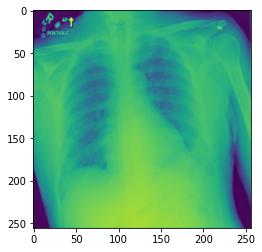

In [ ]:
plt.imshow(img[:,:,0])

In [ ]:
np.unique(mask)

array([0.])

# New Section

# New Section

# New Section

# New Section

# New Section

# New Section

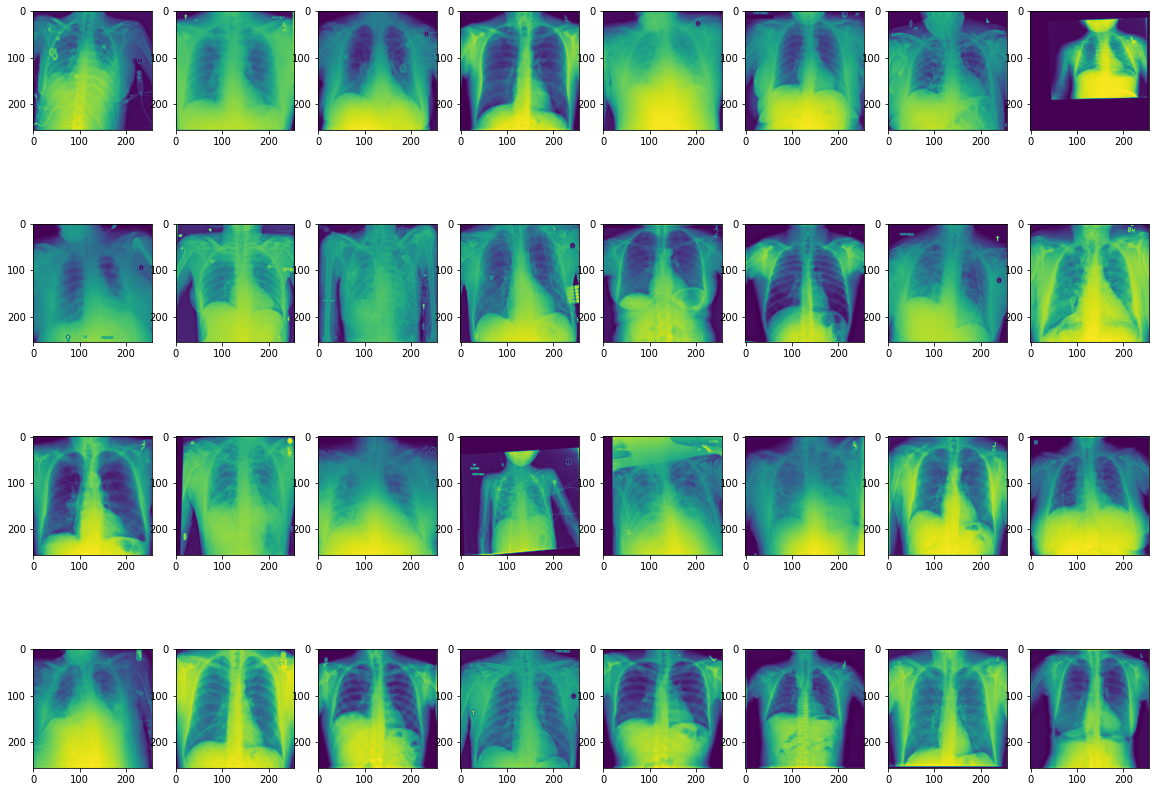

In [ ]:


for imgs, msks in valid_gen:
    # predict batch of images
    preds = model1.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected componentsf
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break
